In [1]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
from logging import getLogger
import seaborn as sns
import matplotlib.pyplot as plt

from src.models.utils import callbacks
from src.preprocessing.computer_vision import augmentation, scaling
from src.projects.eurosat.architecture import FCNNetwork, CNNNetwork

/Users/gianrond/miniforge3/envs/tensorflow_ml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
_log = getLogger()
model_save_fp = Path(os.getcwd()) / Path('trained_models') / Path('eurosat')

In [3]:
train_dataset, validation_dataset, test_dataset = tfds.load(
    "eurosat/rgb", as_supervised=True, split=["train[:80%]", "train[80%:90%]", "train[90%:]"]
)
_, info = tfds.load(
    "eurosat/rgb", as_supervised=True, with_info=True,
)

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-12-02 11:40:33.605128: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-02 11:40:33.605271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# Labels
class_names = info.features["label"].names
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Plotting some random images with their label

In [5]:
def plot_random_images(dataset: tf.data.Dataset, sample_size :int):
    random_images = []
    sqrt_sample = int(np.sqrt(sample_size))

    for el in dataset.shuffle(1000).take(sqrt_sample*sqrt_sample):
        image, label = el
        label_name = class_names[label.numpy()]
        random_images.append((label_name, image))

    fig, axs = plt.subplots(nrows=sqrt_sample, ncols=sqrt_sample, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle("Sample Images", fontsize=14, y=0.95)

    for img_tuple, ax in zip(random_images, axs.ravel()):
        label, img = img_tuple
        ax.imshow(img)
        ax.set_title(label)
    plt.show()


2022-12-02 11:40:33.763440: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-02 11:40:33.803084: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


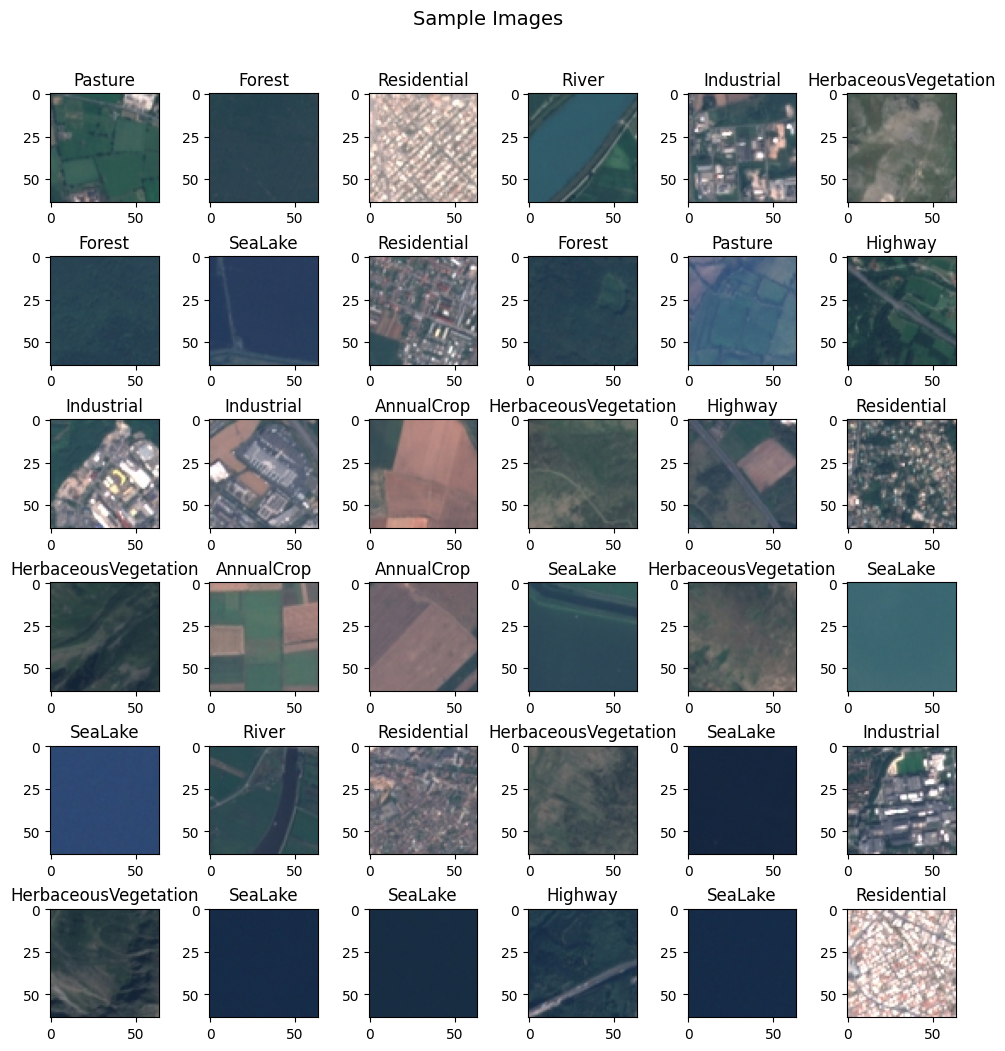

In [6]:
plot_random_images(train_dataset, 36)

The next steps will be about preprocessing the images: we will randomly flip them, adjust the brightness and the contrast. Since all images have the same size we don't need to crop or resize them

2022-12-02 11:40:35.230226: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


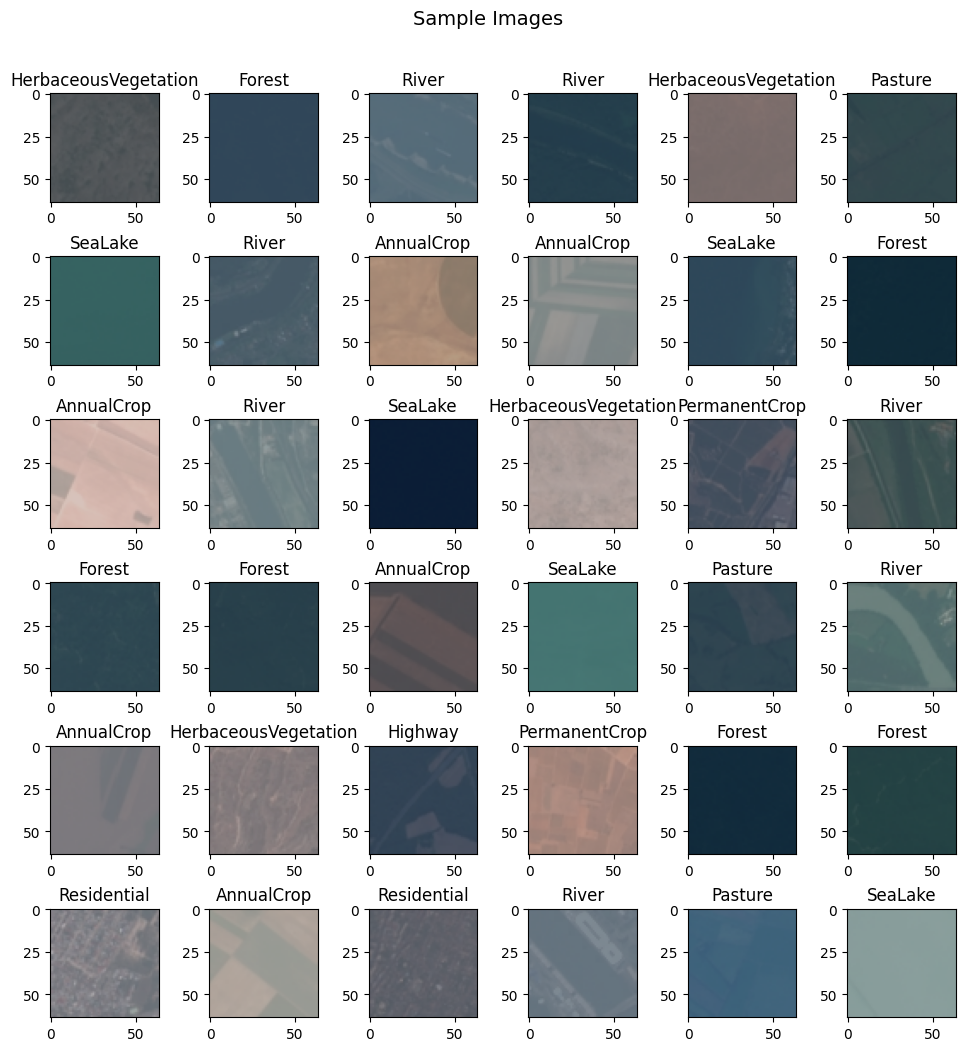

In [7]:
train_dataset = train_dataset.map(lambda image, label: (augmentation(image), label))
plot_random_images(train_dataset, 36)
train_dataset = train_dataset.map(lambda image, label: (scaling(image), label))
validation_dataset = validation_dataset.map(lambda image, label: (augmentation(image), label))
validation_dataset = validation_dataset.map(lambda image, label: (scaling(image), label))

In [8]:
batch_size = 32
train_dataset = train_dataset.shuffle(2000, reshuffle_each_iteration=True).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
name = 'CNNNetwork'
artifacts_path = model_save_fp / Path(name)
model = CNNNetwork(name=name, filepath=artifacts_path)
model = model.connect_layers()
epochs = 100
model.fit(
    x=train_dataset, 
    validation_data=validation_dataset, 
    epochs=epochs, 
    callbacks=callbacks(),
    steps_per_epoch=600,
    validation_steps=600,
)
model.save(artifacts_path)
_log.info(f"Saved {model.name} in folder {artifacts_path}")

Model: "CNNNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       9728      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 128)       0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                      

2022-12-02 11:40:55.883724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


599/600 [============================>.] - ETA: 0s - loss: 5.6988 - accuracy: 0.2788

2022-12-02 11:41:18.399122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


600/600 [==============================] - 30s 47ms/step - loss: 5.6931 - accuracy: 0.2791 - val_loss: 3.2278 - val_accuracy: 0.1622 - lr: 0.0010
Epoch 2/100
600/600 [==============================] - 27s 45ms/step - loss: 1.7536 - accuracy: 0.3985 - val_loss: 1.9088 - val_accuracy: 0.3385 - lr: 0.0010
Epoch 3/100
600/600 [==============================] - 27s 44ms/step - loss: 1.5378 - accuracy: 0.4403 - val_loss: 1.7977 - val_accuracy: 0.3666 - lr: 0.0010
Epoch 4/100
600/600 [==============================] - 27s 45ms/step - loss: 1.4495 - accuracy: 0.4730 - val_loss: 2.3125 - val_accuracy: 0.2977 - lr: 0.0010
Epoch 5/100
600/600 [==============================] - 27s 45ms/step - loss: 1.3755 - accuracy: 0.4986 - val_loss: 1.5995 - val_accuracy: 0.4242 - lr: 0.0010
Epoch 6/100
600/600 [==============================] - 27s 44ms/step - loss: 1.3349 - accuracy: 0.5115 - val_loss: 1.4415 - val_accuracy: 0.4765 - lr: 0.0010
Epoch 7/100
600/600 [==============================] - 27s 44ms/

INFO:tensorflow:Assets written to: /Users/gianrond/git/deeplearning/trained_models/eurosat/CNNNetwork/assets


INFO:tensorflow:Assets written to: /Users/gianrond/git/deeplearning/trained_models/eurosat/CNNNetwork/assets


In [11]:
name = 'FCNNetwork'
artifacts_path = model_save_fp / Path(name)
model = FCNNetwork(name=name, filepath=artifacts_path)
model = model.connect_layers()
epochs = 100
model.fit(
    x=train_dataset, 
    validation_data=validation_dataset, 
    epochs=epochs, 
    callbacks=callbacks(),
    steps_per_epoch=600,
    validation_steps=600,
)
model.save(artifacts_path)
_log.info(f"Saved {model.name} in folder {artifacts_path}")

Model: "FCNNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 128)   9728      
                                                                 
 batch_normalization_7 (Batc  (None, None, None, 128)  512       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, None, None, 128)   0         
                                                                 
 dropout_6 (Dropout)         (None, None, None, 128)   0         
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 256)   295168    
                                                        

2022-12-02 13:33:00.900110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


600/600 [==============================] - ETA: 0s - loss: 1.7537 - accuracy: 0.3461

2022-12-02 13:33:23.462078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


600/600 [==============================] - 30s 49ms/step - loss: 1.7537 - accuracy: 0.3461 - val_loss: 1.7129 - val_accuracy: 0.3566 - lr: 0.0010
Epoch 2/100
600/600 [==============================] - 29s 48ms/step - loss: 1.5446 - accuracy: 0.4328 - val_loss: 1.5741 - val_accuracy: 0.4291 - lr: 0.0010
Epoch 3/100
600/600 [==============================] - 29s 48ms/step - loss: 1.4856 - accuracy: 0.4571 - val_loss: 1.4972 - val_accuracy: 0.4518 - lr: 0.0010
Epoch 4/100
600/600 [==============================] - 29s 48ms/step - loss: 1.4247 - accuracy: 0.4784 - val_loss: 1.7640 - val_accuracy: 0.3525 - lr: 0.0010
Epoch 5/100
600/600 [==============================] - 29s 48ms/step - loss: 1.3655 - accuracy: 0.5029 - val_loss: 1.4025 - val_accuracy: 0.4860 - lr: 0.0010
Epoch 6/100
600/600 [==============================] - 29s 48ms/step - loss: 1.3400 - accuracy: 0.5177 - val_loss: 1.4740 - val_accuracy: 0.4766 - lr: 0.0010
Epoch 7/100
600/600 [==============================] - 29s 48ms/

INFO:tensorflow:Assets written to: /Users/gianrond/git/deeplearning/trained_models/eurosat/FCNNetwork/assets


INFO:tensorflow:Assets written to: /Users/gianrond/git/deeplearning/trained_models/eurosat/FCNNetwork/assets
